In [2]:
import os
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from skimage.io import imread, imshow
from skimage.transform import resize

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

## Loading and spliting train data

In [4]:
def get_train_data():
    train_ids = next(os.walk("stage1_train"))[1]

    x_train_f = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    y_train_f = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    for n, img_id in enumerate(train_ids):
        path = "./stage1_train/" + img_id
        img = imread(path + "/images/" + img_id + ".png")[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
        x_train_f[n] = img

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_id in os.listdir(path + "/masks/"):
            mask_file = imread(path + "/masks/" + mask_id)
            mask_file = np.expand_dims(resize(mask_file, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True),
                                      axis=-1)
            mask = np.maximum(mask, mask_file)
        y_train_f[n] = mask

        if n%100 == 0 and n != 0 or n == 669:
            print(f"Load {n} images")
    
    return train_test_split(x_train_f, y_train_f, test_size=0.2)

## Loading test data

In [5]:
def get_test_data():
    test_ids = next(os.walk("stage1_test"))[1]

    x_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    test_img_sizes = []

    for n, img_id in enumerate(test_ids):
        path = "./stage1_test/" + img_id
        img = imread(path +  "/images/" + img_id + ".png")[:, :, :IMG_CHANNELS]
        test_img_sizes.append(img.shape)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
        x_test[n] = img

    print("Done.")
    return x_test, test_img_sizes

## Define special metric (dice coefficient)

In [6]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true)) + K.sum(K.square(y_pred)) + smooth)

## Defining UNet model 

In [7]:
def get_UNet_model(filters_dim: list, activation="relu", kernel_init="he_normal", padding="same"):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    new_inputs = Lambda(lambda x: x / 255) (inputs)
    conv_layers = []
    
    #encoder
    for i in range(len(filters_dim) - 1):
        conv = Conv2D(filters_dim[i], (3,3), activation=activation, padding=padding, kernel_initializer=kernel_init) (new_inputs)
        conv = Conv2D(filters_dim[i], (3,3), activation=activation, padding=padding, kernel_initializer=kernel_init) (conv)
        conv_layers.append(conv)
        new_inputs = MaxPooling2D(pool_size=(2, 2)) (conv)
        
    #bridge
    conv = Conv2D(filters_dim[-1], (3,3), activation=activation, padding=padding, kernel_initializer=kernel_init) (new_inputs)
    conv = Conv2D(filters_dim[-1], (3,3), activation=activation, padding=padding, kernel_initializer=kernel_init) (conv)
    new_inputs = Dropout(0.5) (conv)
    
    filters_dim.reverse()
    conv_layers.reverse()
    
    #decoder
    for i in range(1, len(filters_dim)):
        up = Conv2DTranspose(filters_dim[i], (2, 2), strides=(2, 2), padding=padding) (new_inputs)
        concat = concatenate([up, conv_layers[i-1]])
        conv = Conv2D(filters_dim[i], (3,3), activation=activation, padding=padding, kernel_initializer=kernel_init) (concat)
        new_inputs = Conv2D(filters_dim[i], (3,3), activation=activation, padding=padding, kernel_initializer=kernel_init) (conv)
        
    outputs = Conv2D(1, (1,1), activation="sigmoid") (new_inputs)
    model = Model(inputs=[inputs], outputs=[outputs], name="UNet")
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[dice_coefficient])
    return model

In [8]:
x_train, x_test, y_train, y_test = get_train_data()

Load 100 images
Load 200 images
Load 300 images
Load 400 images
Load 500 images
Load 600 images
Load 669 images


## Fitting model and getting results

In [9]:
def fit_model():
    unet = get_UNet_model([16, 32, 64, 128, 256])
#     x_train, x_test, y_train, y_test = get_train_data()
    
    early_stopper = EarlyStopping(patience=5, verbose=1)
    check_pointer = ModelCheckpoint("model-weights.h5", verbose=1, save_best_only=True)
    
    results = unet.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[early_stopper, check_pointer])
    
    return results

In [10]:
res = fit_model()
res

Train on 482 samples, validate on 54 samples
Epoch 1/50
480/482 [============================>.] - ETA: 0s - loss: 0.5535 - dice_coefficient: 0.4102
Epoch 00001: val_loss improved from inf to 0.38370, saving model to model-weights.h5
482/482 [==============================] - 14s 29ms/sample - loss: 0.5523 - dice_coefficient: 0.4072 - val_loss: 0.3837 - val_dice_coefficient: 0.3793
Epoch 2/50
480/482 [============================>.] - ETA: 0s - loss: 0.3167 - dice_coefficient: 0.5776
Epoch 00002: val_loss improved from 0.38370 to 0.24082, saving model to model-weights.h5
482/482 [==============================] - 5s 10ms/sample - loss: 0.3155 - dice_coefficient: 0.5827 - val_loss: 0.2408 - val_dice_coefficient: 0.6913
Epoch 3/50
480/482 [============================>.] - ETA: 0s - loss: 0.2011 - dice_coefficient: 0.7874
Epoch 00003: val_loss improved from 0.24082 to 0.15851, saving model to model-weights.h5
482/482 [==============================] - 5s 10ms/sample - loss: 0.2005 - dice

## Plots for main dependencies

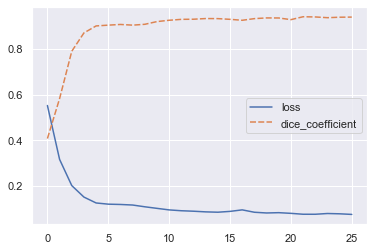

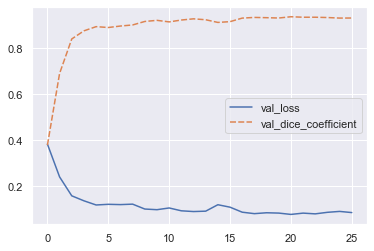

In [15]:
history = pd.DataFrame(data=res.history, columns=list(res.history))
sns.lineplot(data=history.iloc[:, :2])
plt.show()
sns.lineplot(data=history.iloc[:, 2:])
plt.show()

## Predict on labled test data

Image


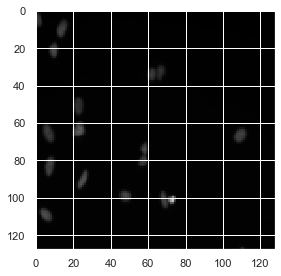

True mask


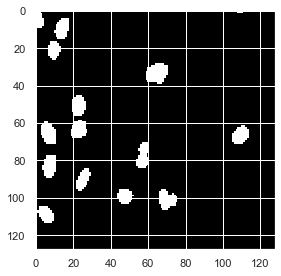

Predicted mask


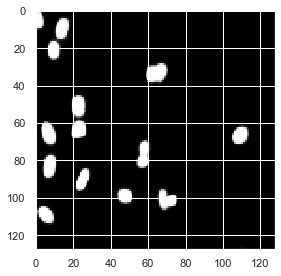

In [17]:
model = load_model("model-weights.h5", custom_objects={"dice_coefficient": dice_coefficient})
pred_test = model.predict(x_test, verbose=0)

x = np.random.randint(0, len(pred_test))
print("Image")
imshow(x_test[x])
plt.show()
print("True mask")
imshow(np.squeeze(y_test[x]))
plt.show()
print("Predicted mask")
imshow(np.squeeze(pred_test[x]))
plt.show()

## Getting result on unlabled test data

In [29]:
def predict():
    x_test, test_sizes = get_test_data()
    model = load_model("model-weights.h5", custom_objects={"dice_coefficient": dice_coefficient})

    predict_test = model.predict(x_test, verbose=0)
    pred_test_mask = (predict_test > 0.5).astype(np.uint8)

    pred_test_unsampled = []
    for i in range(len(predict_test)):
        pred_test_unsampled.append(resize(np.squeeze(predict_test[i]), test_sizes[i], mode="constant", preserve_range=True))
    
    x = np.random.randint(0, len(pred_test))
    
    print("Image")
    imshow(np.squeeze(x_test[x]))
    plt.show()
    
    print("Predicted mask")
    imshow(np.squeeze(pred_test_mask[x]))
    plt.show()
    
    return pred_test_unsampled

Done.
Image


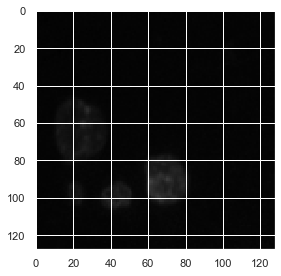

Predicted mask


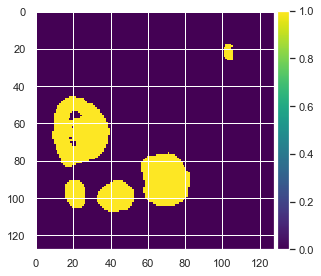

In [31]:
pred_masks = predict()